# Import libraries

In [1]:
# Re-install transformers
# !pip install -q transformers==4.55.4 faiss-cpu

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Sampler, DataLoader

import numpy as np
from safetensors.torch import load_model

In [3]:
from transformers import (
    BertTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    ErnieConfig,
    ErnieModel,
    EarlyStoppingCallback,
)

In [4]:
import gc
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, recall_score, precision_score

In [5]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# Set seed for deterministic

In [6]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
# torch.use_deterministic_algorithms(True) 

# Constants

In [7]:
PATH_TO_DATASET = '/mnt/d/SemEval2026/subtask3'
MODEL_NAME = '/mnt/d/SemEval2026/ernie-3.0-xbase-zh'
BATCH_SIZE_TRAIN = 8
BATCH_SIZE_EVAL = 32

MODEL_HEAD_DROPOUT = 0.1

LANG = 'zho'
NUM_CLASSES = 6
K_FOLDS = 5

SAVE_DIR = f'/mnt/d/SemEval2026/Ernie3-Sub3-Final-{LANG}'
TEMP_DIR = f'/mnt/d/SemEval2026/Ernie3-Sub3-temp-{LANG}'

In [8]:
SUBTASK1_FOLD_MODELS_DIR = f'/mnt/d/SemEval2026/Ernie3-Sub1-Final-{LANG}'
# SUBTASK1_TEST_PREDICTION = f'/mnt/d/SemEval2026/Ernie3-Sub1-Final-{LANG}/subtask_1/pred_{LANG}.csv'
SUBTASK1_TEST_PREDICTION = f'/mnt/d/SemEval2026/Ernie3-Sub1-Final-{LANG}/test/subtask_1/pred_{LANG}.csv'

In [9]:
SUBTASK2_COLUMNS = ['political', 'racial/ethnic', 'religious', 'gender/sexual', 'other']
SUBTASK3_COLUMNS = ['stereotype','vilification','dehumanization','extreme_language','lack_of_empathy','invalidation']

# Loss function

In [10]:
class AsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''

    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False, reduction='sum'):
        super(AsymmetricLossOptimized, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None
        self.reduction = reduction

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))

        # Asymmetric Focusing
        # if self.gamma_neg > 0 or self.gamma_pos > 0:
        if self.disable_torch_grad_focal_loss:
            torch.set_grad_enabled(False)
        self.xs_pos = self.xs_pos * self.targets
        self.xs_neg = self.xs_neg * self.anti_targets
        self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                        self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
        if self.disable_torch_grad_focal_loss:
            torch.set_grad_enabled(True)
        self.loss *= self.asymmetric_w

        if self.reduction == 'sum':
            return -self.loss.sum()
        elif self.reduction == 'mean':
            return -self.loss.mean()
        else:
            return -self.loss

# Prepare tokenizer and model

In [11]:
class ErnieSoftTripleModel_MultiLabel(nn.Module):
    def __init__(self, 
                 model_name='nghuyong/ernie-3.0-xbase-zh', 
                 num_classes=NUM_CLASSES, dropout=0.1, load_pretrained_encoder=True,
                 disable_asl=False,
                 asl_gamma_neg=4, asl_gamma_pos=1, asl_clip=0.05, asl_eps=1e-8,
                 asl_disable_torch_grad_focal_loss=False, asl_reduction='sum'
                 ):
        super().__init__()
        if load_pretrained_encoder:
            self.encoder = ErnieModel.from_pretrained(model_name)
        else:
            self.encoder = ErnieModel(ErnieConfig.from_pretrained(model_name))
        self.config = self.encoder.config
        self.hidden_size = self.config.hidden_size
        self.dropout = dropout
        
        self.classifier = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LayerNorm(self.hidden_size),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden_size, num_classes)
        )

        if disable_asl:
            self.loss_fn = None
        else:
            self.loss_fn = AsymmetricLossOptimized(
                gamma_neg=asl_gamma_neg,
                gamma_pos=asl_gamma_pos,
                clip=asl_clip,
                eps=asl_eps,
                disable_torch_grad_focal_loss=asl_disable_torch_grad_focal_loss,
                reduction=asl_reduction
            )

    def forward(self, input_ids, attention_mask, labels=None, **kwargs):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)

        # 1. Extract [CLS] Token (Intent)
        cls_embedding = outputs.last_hidden_state[:, 0, :] # [Batch, Hidden]

        # Project to metric space (Stage 1)
        logits = self.classifier(cls_embedding)
        cls_embedding = F.normalize(cls_embedding, p=2, dim=1)

        loss = None
        if labels is not None and self.loss_fn is not None:
            loss = self.loss_fn(logits, labels)

        return {'loss': loss, 'logits': logits, 'embeddings': cls_embedding}

In [12]:
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Prepare dataset

In [13]:
class PolarizationDataset(torch.utils.data.Dataset):
  def __init__(self, data, tokenizer, max_length=96):
    """
    Args:
      data: Dict with 'texts', 'labels', and 'ids' keys
    """
    self.tokenizer = tokenizer
    self.max_length = max_length

    if isinstance(data, dict):
      self.texts = data['texts']
      self.labels = data['labels']
      # Add ID support. If not present, generate dummy IDs (0...N)
      self.ids = data.get('ids', list(range(len(self.texts))))
    else:
      raise ValueError("Data must be a single dict with 'texts', 'labels', and 'ids'")

    self.has_labels = any(label is not None for label in self.labels)

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx] if self.has_labels else None
    sample_id = self.ids[idx]

    encoding = self.tokenizer(
      text,
      truncation=True,
      padding='max_length', # Changed to max_length for consistent tensor shapes in batch
      max_length=self.max_length,
      return_tensors='pt'
    )

    item = {key: encoding[key].squeeze() for key in encoding.keys()}

    if label is not None:
      item['labels'] = torch.tensor(label, dtype=torch.float32)
    
    # Return ID so we can verify if needed, though Sampler handles the logic
    item['id'] = sample_id 

    return item

In [14]:
train_path = PATH_TO_DATASET + f'/train/{LANG}.csv'
df = pd.read_csv(train_path)
df = df[df[SUBTASK3_COLUMNS].sum(axis=1) > 0]

In [15]:
mskf = MultilabelStratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

In [16]:
fold_idx = []
for train_idx, val_idx in mskf.split(df, df[SUBTASK3_COLUMNS].values):
    fold_idx.append((train_idx, val_idx))

# Training process

## Collator

In [17]:
data_collator = DataCollatorWithPadding(tokenizer)

# Inferences on test set

## Load all fold models

In [18]:
model_list = []
for i in range(K_FOLDS):
    print(f"Intialize model fold {i+1}")
    model = ErnieSoftTripleModel_MultiLabel(
        model_name=MODEL_NAME, 
        num_classes=NUM_CLASSES, 
        dropout=MODEL_HEAD_DROPOUT, 
        load_pretrained_encoder=False,
        disable_asl=True,  # Disable ASL for this ablation
    )
    load_model(model, f"{SAVE_DIR}/fold_{i+1}_best_model/model.safetensors")
    model.eval()
    model.cuda()
    model_list.append(model)

Intialize model fold 1
Intialize model fold 2
Intialize model fold 3
Intialize model fold 4
Intialize model fold 5


## Load test dataset (same for all subtasks)

In [19]:
# PUBLIC TEST WITH LABELS
PATH_TO_PUBLIC_TEST_WITH_LABELS = '/mnt/d/SemEval2026/test_phase/subtask3/dev'
test = pd.read_csv(PATH_TO_PUBLIC_TEST_WITH_LABELS + f'/{LANG}.csv')
test = test[test[SUBTASK3_COLUMNS].sum(axis=1) > 0]
test_dataset = PolarizationDataset({
    'texts': test['text'].tolist(),
    'labels': [None] * len(test)
}, tokenizer=tokenizer)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE_EVAL,
    shuffle=False,
    collate_fn=data_collator
)

## Generate the result

In [20]:
val_probs, test_probs = [], []

In [21]:
for fold_ids, (_, fold_val) in enumerate(fold_idx):
    print(f"Predicting with fold {fold_ids+1}")
    model = model_list[fold_ids]

    # Validation Predictions
    fold_val_data = {
        'texts': [df['text'][j] for j in fold_val],
        'labels': [df[SUBTASK3_COLUMNS].iloc[j].to_list() for j in fold_val]
    }
    fold_val_dataset = PolarizationDataset(fold_val_data, tokenizer)
    fold_val_dataloader = DataLoader(
        fold_val_dataset,
        batch_size=BATCH_SIZE_EVAL,
        shuffle=False,
        collate_fn=data_collator
    )

    all_val_probs = []
    with torch.no_grad():
        for batch in fold_val_dataloader:
            input_ids = batch['input_ids'].cuda()
            attention_mask = batch['attention_mask'].cuda()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs['logits']
            probs = torch.sigmoid(logits).cpu().numpy()
            all_val_probs.append(probs)
    
    all_val_probs = np.vstack(all_val_probs)
    val_probs.append(all_val_probs)

    # Test Predictions
    all_test_probs = []
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].cuda()
            attention_mask = batch['attention_mask'].cuda()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs['logits']
            probs = torch.sigmoid(logits).cpu().numpy()
            all_test_probs.append(probs)
    
    all_test_probs = np.vstack(all_test_probs)
    test_probs.append(all_test_probs)

test_probs = np.mean(test_probs, axis=0)
val_probs = np.concatenate(val_probs, axis=0)

Predicting with fold 1
Predicting with fold 2
Predicting with fold 3
Predicting with fold 4
Predicting with fold 5


In [22]:
ground_truth = test[SUBTASK3_COLUMNS].values

In [23]:
threshold_range = np.linspace(0.01, 0.99, num=99)
best_thresholds = []
for class_idx in range(NUM_CLASSES):
    best_f1_class = 0.0
    best_thresh_class = 0.5
    best_diff = 1.0
    
    for thresh in threshold_range:
        preds_class = (test_probs[:, class_idx] >= thresh).astype(int)
        labels_class = ground_truth[:, class_idx]
        
        f1_class = f1_score(labels_class, preds_class, average='macro', zero_division=0)
        precision = precision_score(labels_class, preds_class, average='macro', zero_division=0)
        recall = recall_score(labels_class, preds_class, average='macro', zero_division=0)

        diff = abs(precision - recall)
        
        if diff < best_diff or (diff == best_diff and f1_class > best_f1_class):
            best_diff = diff
            best_f1_class = f1_class
            best_thresh_class = thresh
            
    best_thresholds.append(best_thresh_class)

best_thresholds

[np.float64(0.8300000000000001),
 np.float64(0.72),
 np.float64(0.7000000000000001),
 np.float64(0.55),
 np.float64(0.54),
 np.float64(0.41000000000000003)]

In [24]:
predicted_labels = (test_probs >= np.array(best_thresholds)).astype(int)

In [25]:
macro_f1 = f1_score(ground_truth, predicted_labels, average='macro')
precision = precision_score(ground_truth, predicted_labels, average='macro')
recall = recall_score(ground_truth, predicted_labels, average='macro')

In [26]:
print(f"Macro F1: {macro_f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

Macro F1: 0.7422, Precision: 0.7453, Recall: 0.7392


In [27]:
for idx, label in enumerate(SUBTASK3_COLUMNS):
    macro_f1 = f1_score(ground_truth[:, idx], predicted_labels[:, idx], average='macro')
    precision = precision_score(ground_truth[:, idx], predicted_labels[:, idx], average='macro')
    recall = recall_score(ground_truth[:, idx], predicted_labels[:, idx], average='macro')
    print(f"{label} >> Macro F1: {macro_f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

stereotype >> Macro F1: 0.8675, Precision: 0.8675, Recall: 0.8675
vilification >> Macro F1: 0.8815, Precision: 0.8815, Recall: 0.8815
dehumanization >> Macro F1: 0.8989, Precision: 0.8989, Recall: 0.8989
extreme_language >> Macro F1: 0.7561, Precision: 0.7561, Recall: 0.7561
lack_of_empathy >> Macro F1: 0.7679, Precision: 0.7749, Recall: 0.7615
invalidation >> Macro F1: 0.8348, Precision: 0.8348, Recall: 0.8348


# Visualize embeddings space

In [28]:
palette = {
    0: 'gray', 1: 'red'
}

In [29]:
def get_embeddings_and_labels(model, dataloader):
    embeddings = []
    labels = []

    # Iterate over the training data in batches
    with torch.no_grad():  # Disable gradient calculation for inference
        for batch in dataloader:
            # Move batch to the same device as the model
            batch = {k: v.to('cuda') for k, v in batch.items()}

            # Get model outputs with hidden states
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], output_hidden_states=True)

            # Extract the embeddings and the labels
            batch_embeddings = outputs['embeddings'].cpu().numpy()
            batch_labels = batch['labels'].cpu().numpy()

            embeddings.append(batch_embeddings)
            labels.append(batch_labels)

    # Concatenate embeddings and labels from all batches
    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)

    return embeddings, labels

In [30]:
def visualize(lang, pca_embeddings, tsne_embeddings, labels):
    # Create subplots: 2 rows (PCA, t-SNE) x len(SUBTASK3_COLUMNS) columns
    num_labels = len(SUBTASK3_COLUMNS)
    fig, axes = plt.subplots(2, num_labels, figsize=(4*num_labels, 10))
    
    # Ensure axes is always 2D
    if num_labels == 1:
        axes = axes.reshape(2, 1)
    
    # Iterate through each label in SUBTASK3_COLUMNS
    for col_idx, label_name in enumerate(SUBTASK3_COLUMNS):
        # Extract binary labels for this specific class
        binary_labels = labels[:, col_idx].astype(int)
        
        # --- PCA Plot for this label ---
        sns.scatterplot(
            x=pca_embeddings[:, 0], 
            y=pca_embeddings[:, 1], 
            hue=binary_labels, 
            palette=palette, 
            legend='full', 
            ax=axes[0, col_idx]
        )
        axes[0, col_idx].set_title(f'PCA - {label_name}')
        axes[0, col_idx].set_xlabel('PCA Component 1')
        axes[0, col_idx].set_ylabel('PCA Component 2')
        
        # --- t-SNE Plot for this label ---
        sns.scatterplot(
            x=tsne_embeddings[:, 0], 
            y=tsne_embeddings[:, 1], 
            hue=binary_labels, 
            palette=palette, 
            legend='full', 
            ax=axes[1, col_idx]
        )
        axes[1, col_idx].set_title(f't-SNE - {label_name}')
        axes[1, col_idx].set_xlabel('t-SNE Component 1')
        axes[1, col_idx].set_ylabel('t-SNE Component 2')
    
    # Adjust layout and display the figure
    fig.tight_layout()
    plt.show()
    
    # Explicitly close the figure object to free up memory
    plt.close(fig)

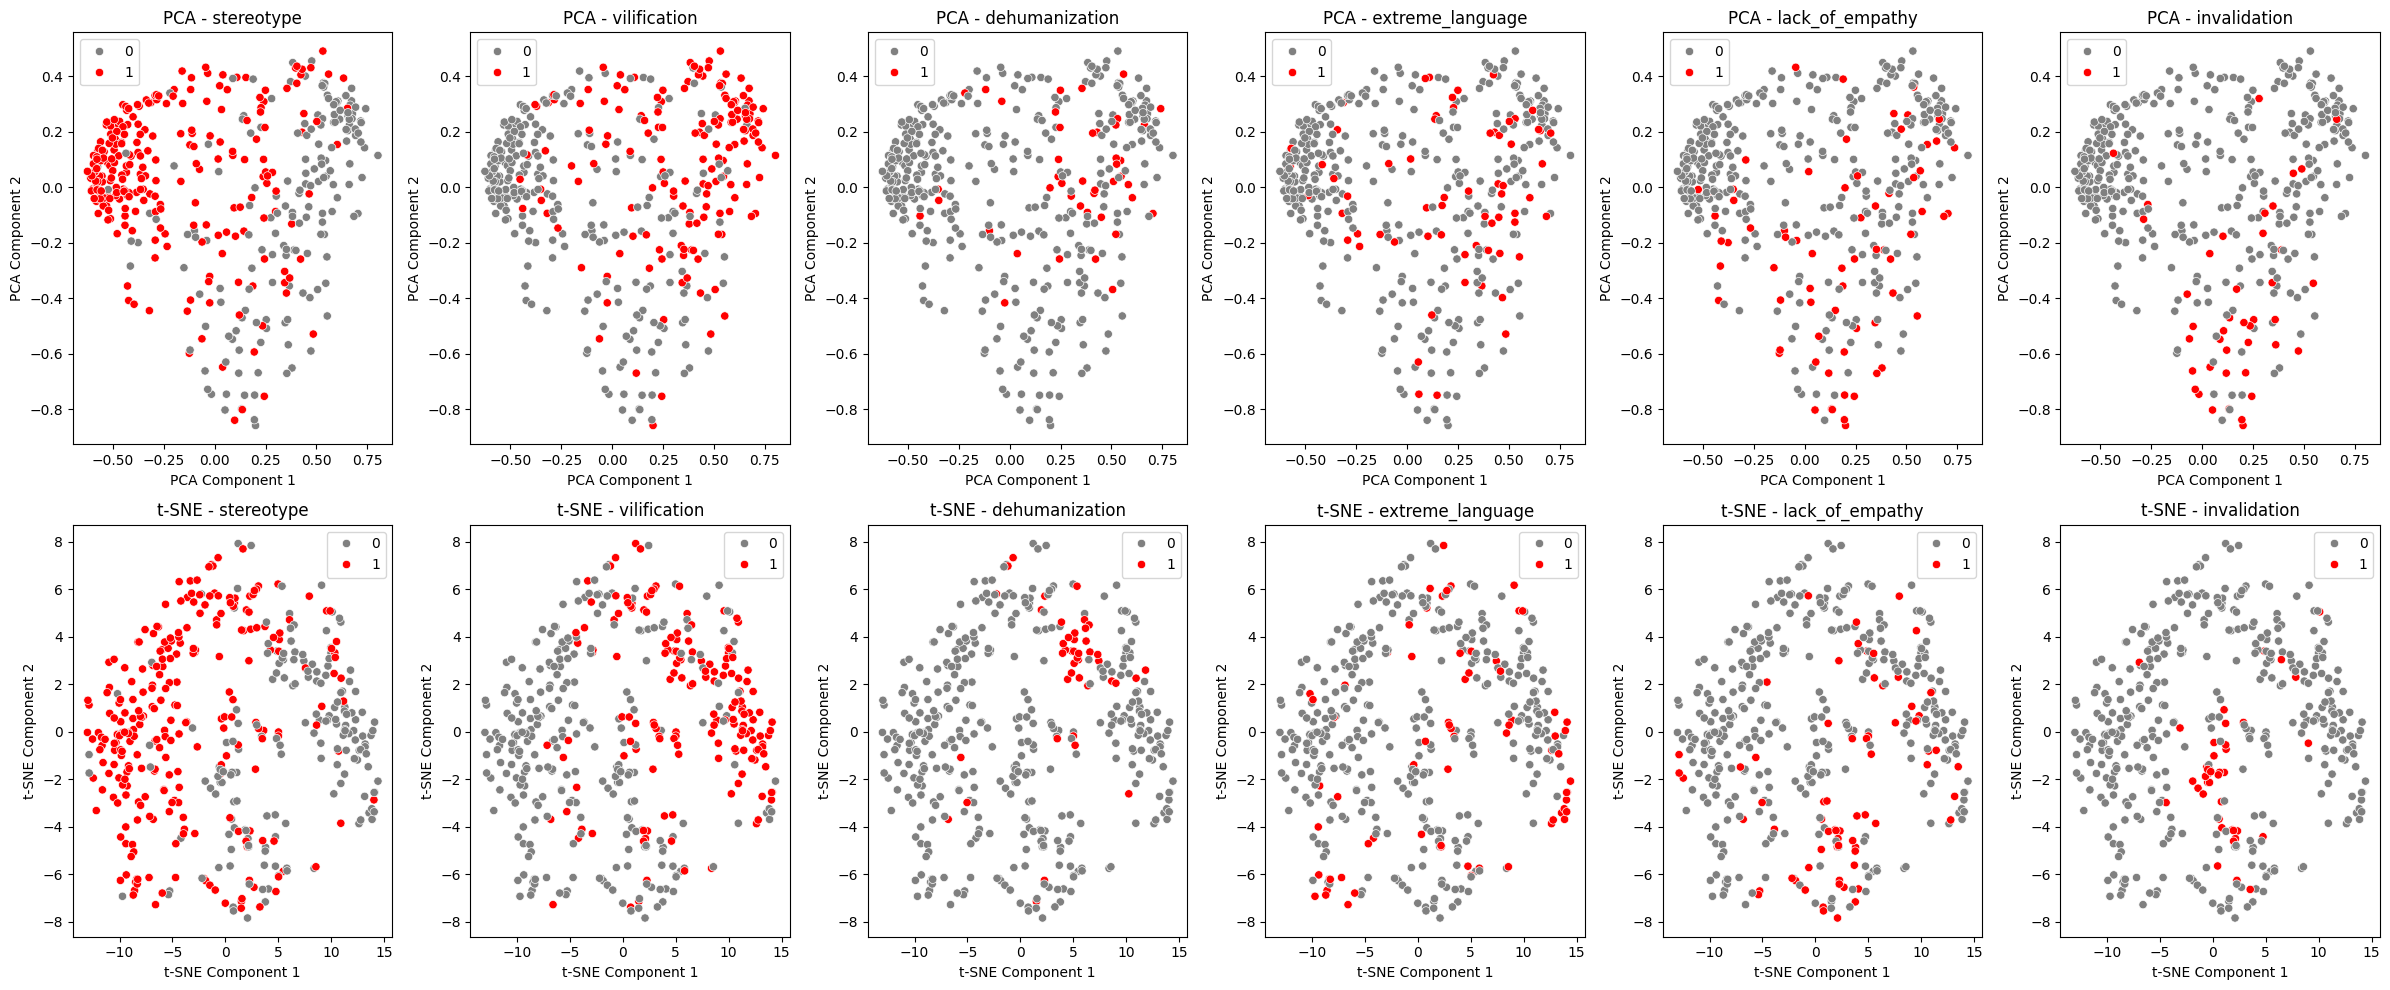

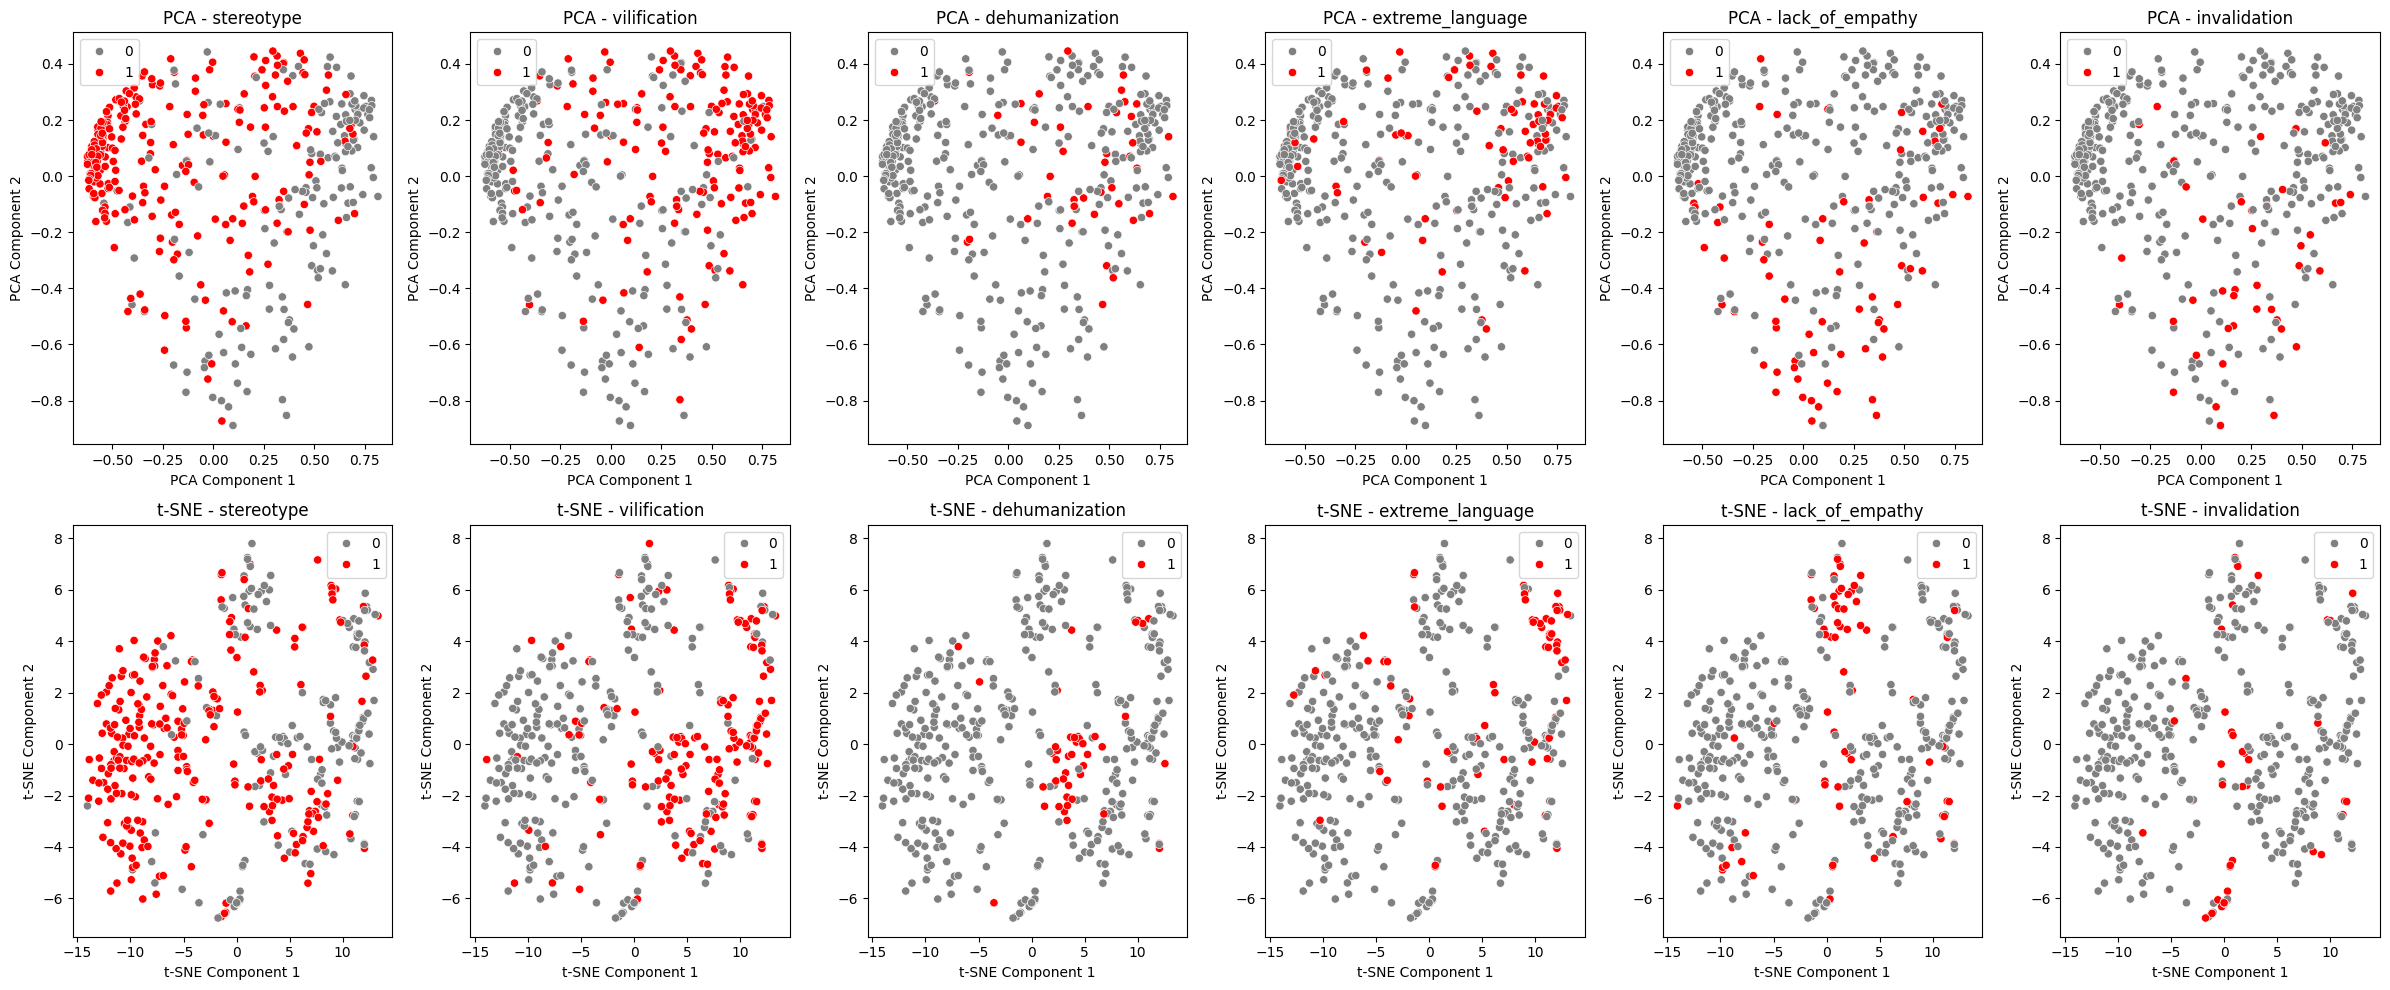

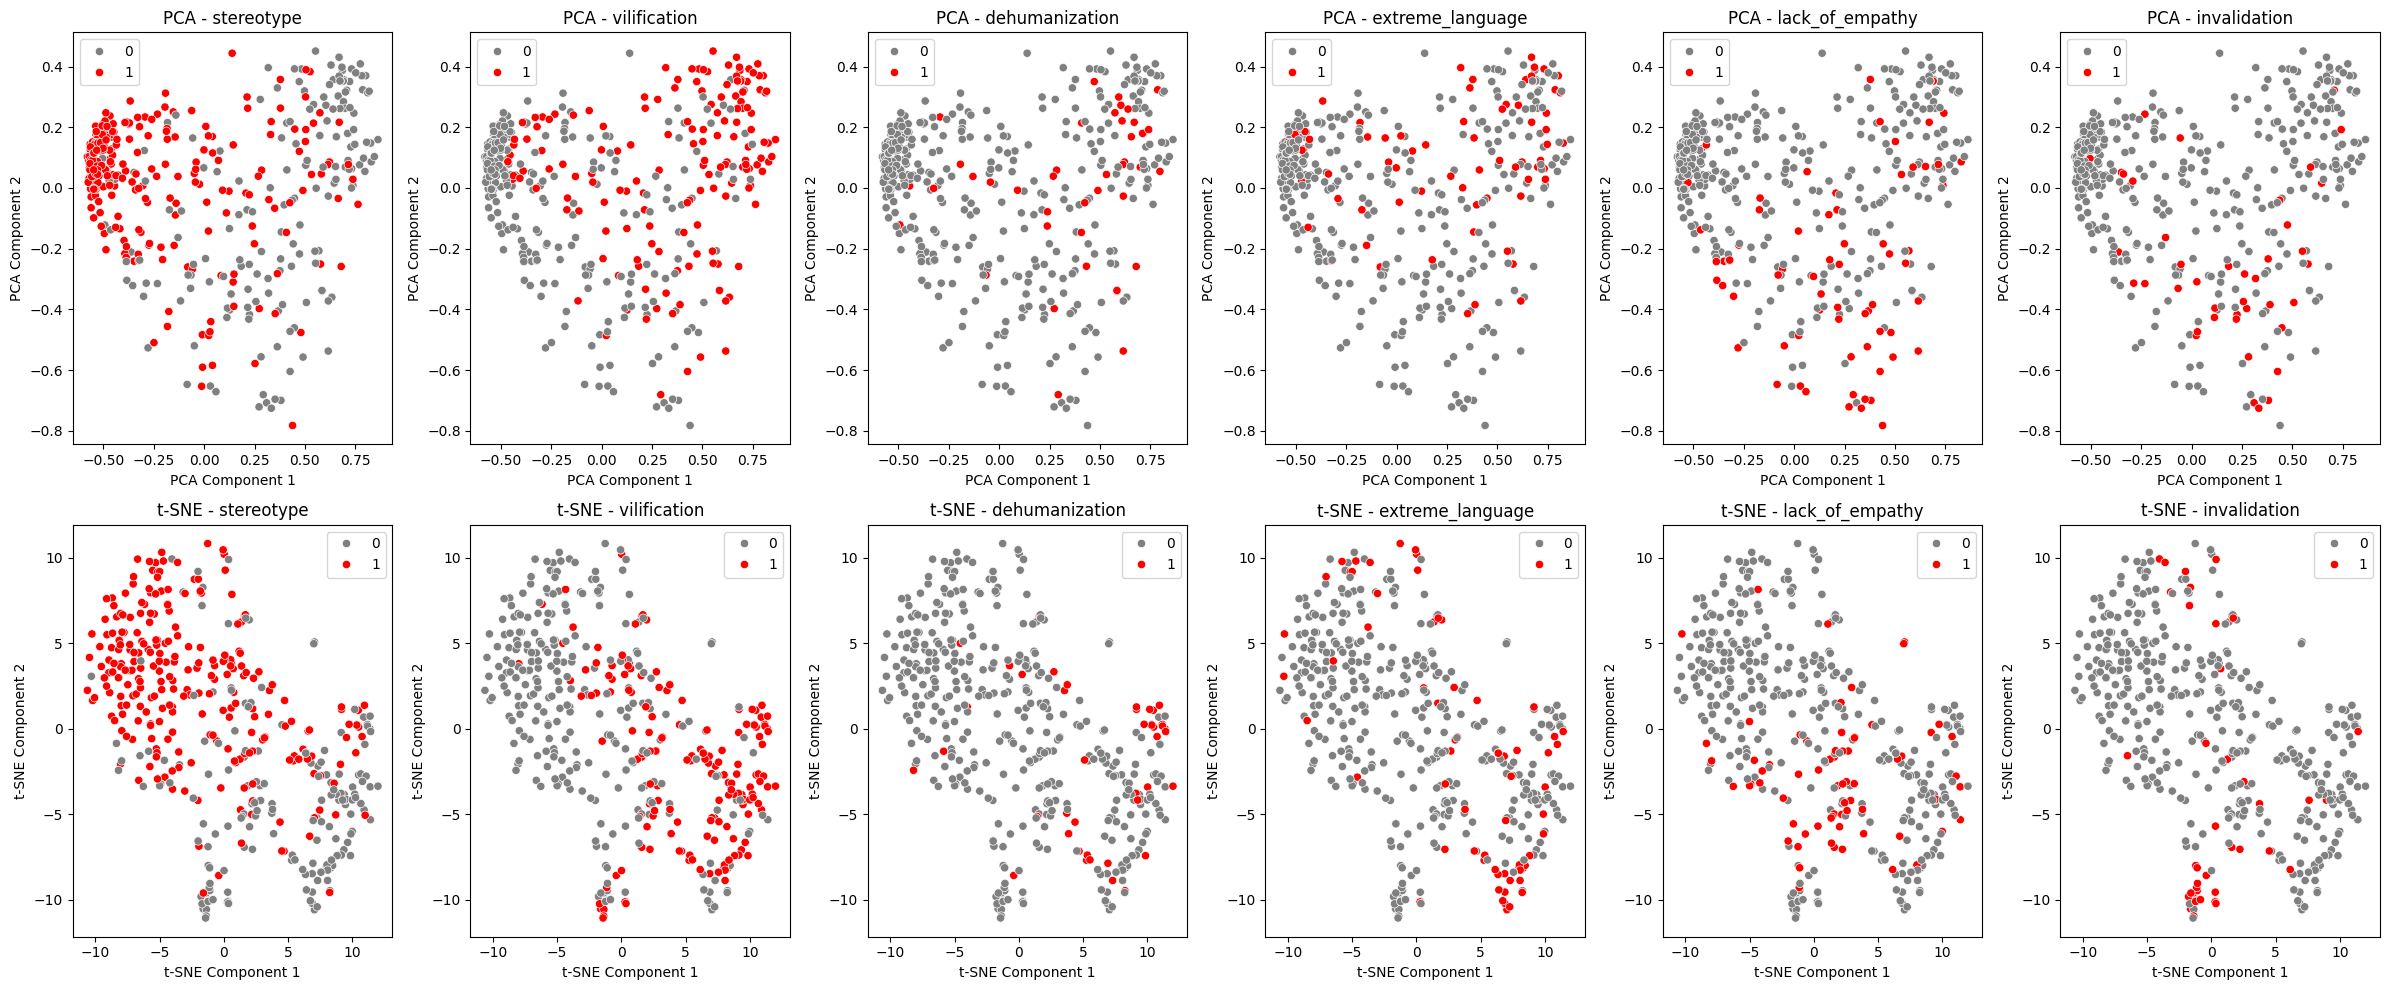

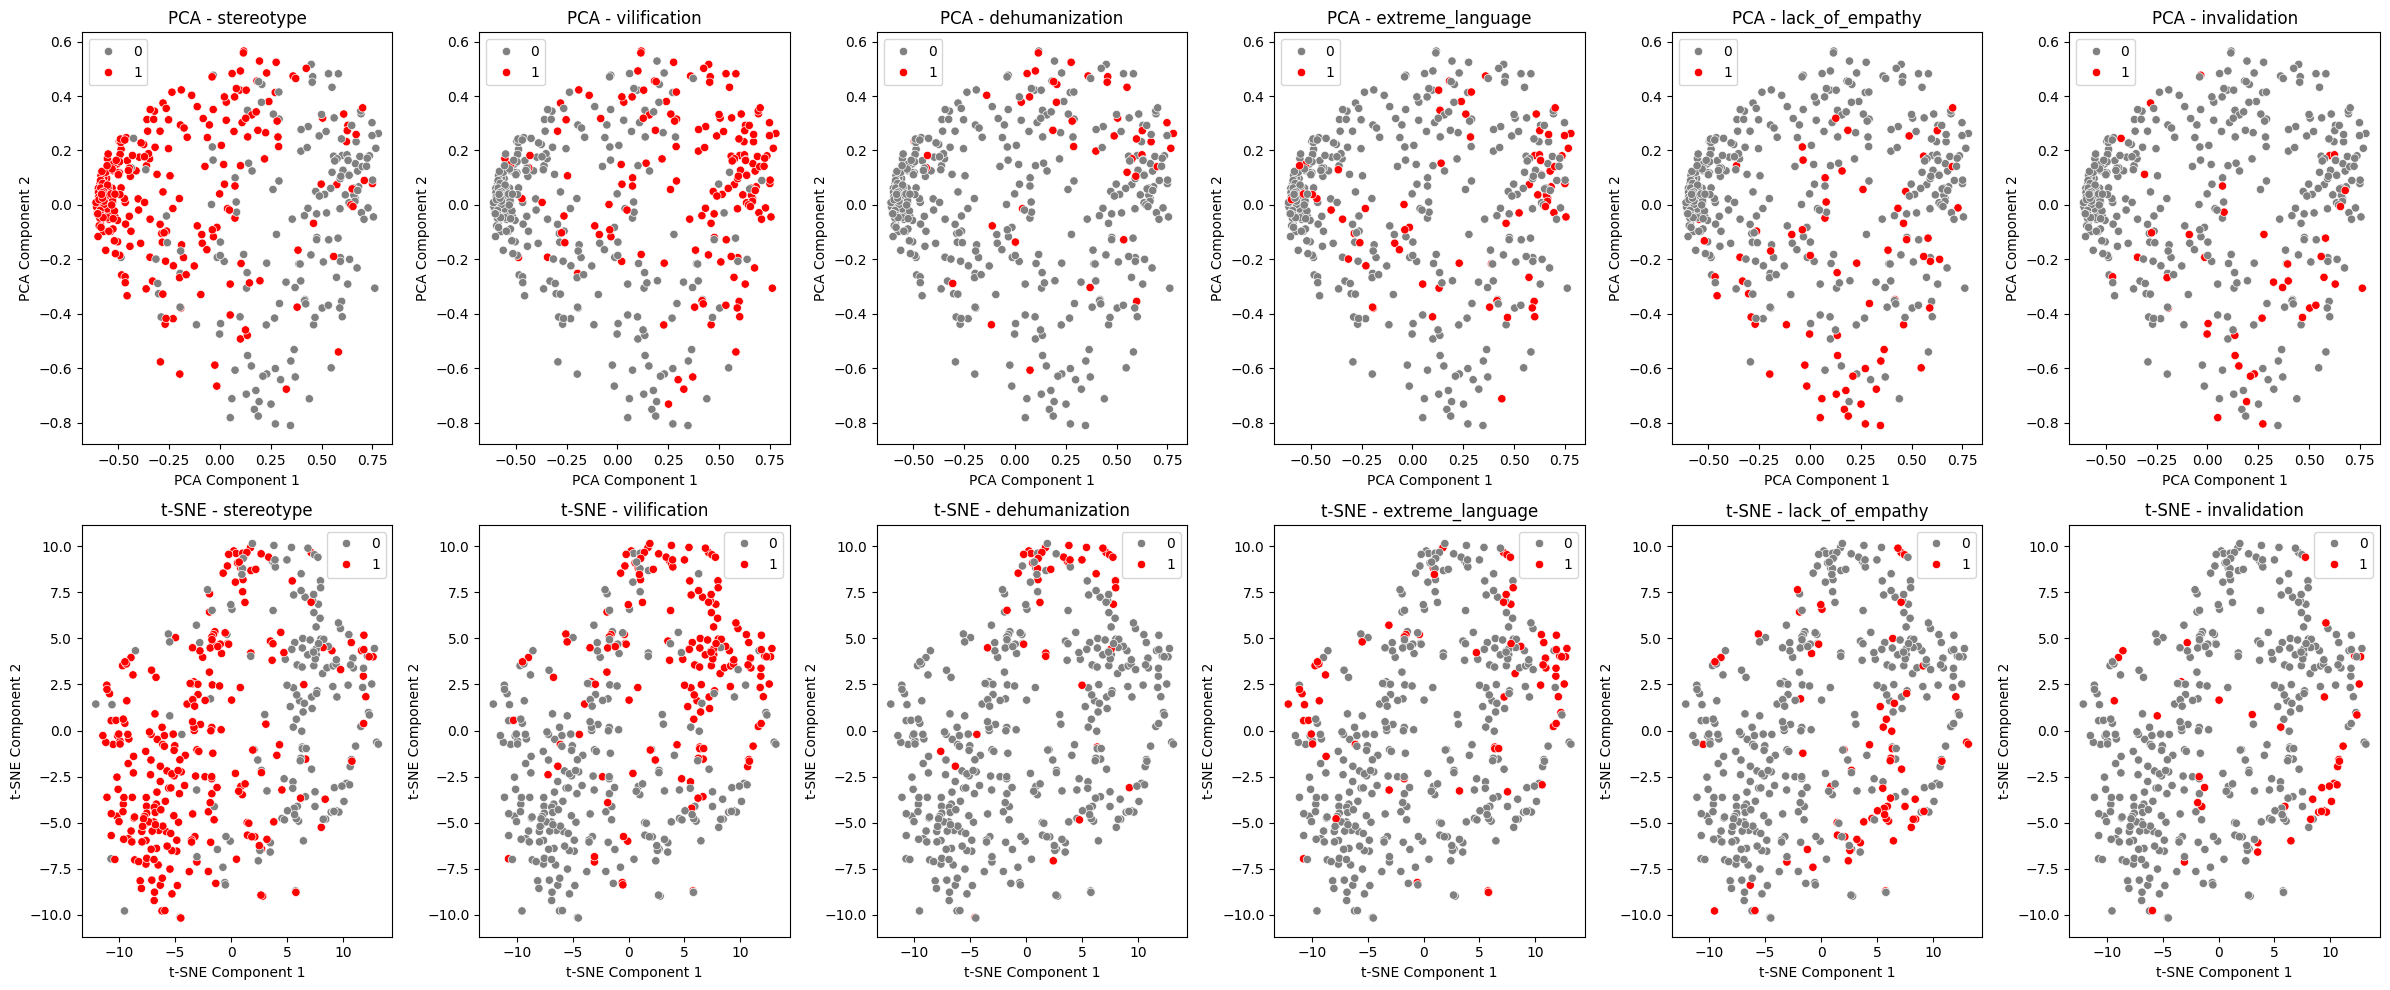

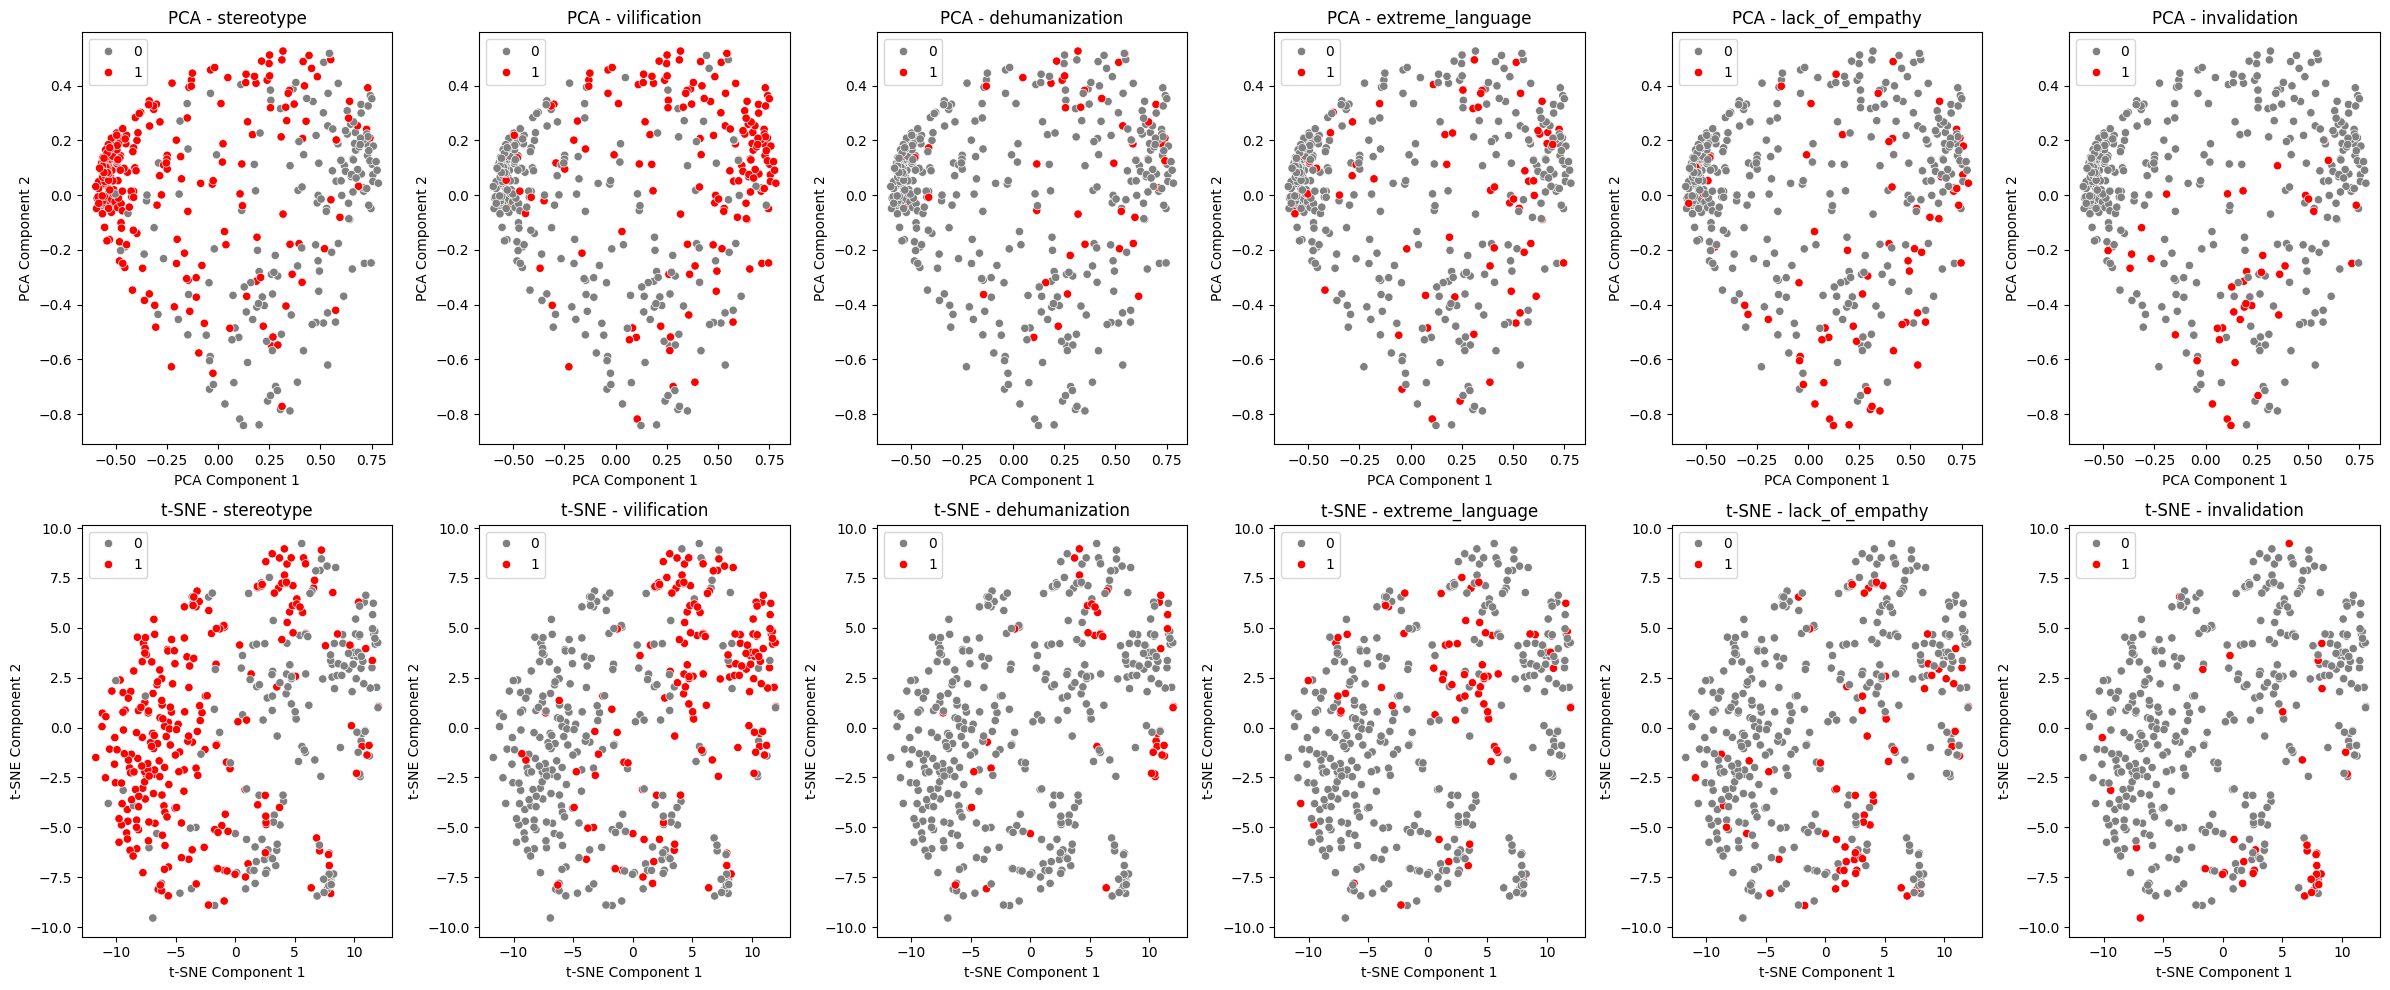

In [31]:
for fold_ids in range(K_FOLDS):
    data_index = fold_idx[fold_ids][1]

    dataset = PolarizationDataset({
        'texts': [df['text'][j] for j in data_index],
        'labels': [df[SUBTASK3_COLUMNS].iloc[j].to_list() for j in data_index]
    }, tokenizer=tokenizer)

    # Create a DataLoader for the training dataset
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE_EVAL, collate_fn=data_collator)

    embeddings, labels = get_embeddings_and_labels(model_list[fold_ids], dataloader)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    pca_embeddings = pca.fit_transform(embeddings)

    # Apply t-SNE for dimensionality reduction (can be computationally intensive)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
    tsne_embeddings = tsne.fit_transform(embeddings)

    visualize(f'val set of fold {fold_ids}', pca_embeddings, tsne_embeddings, labels)